In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import copy
import importlib
import functions
import numpy as np
import json

# import seaborn as sns

importlib.reload(functions)

<module 'functions' from 'c:\\Users\\Lenovo\\Documents\\Études\\Ecole_Ingénieur\\2A\\TR-Economie\\Projet_de_recherche\\analysingEffectOfHealthPlanInFrance\\code\\functions.py'>

# Collecting code LPP under the "100% Santé" plan

### Verification of L_SC1 titles who has been modified, erased or added between 2014 and 2024

#### First solution

In [2]:
diff = {}

for i in range(2024 - 2015):
    df1 = pd.read_csv(
        f"../Open-LPP-data/base_complete/OPEN_LPP_{i+2014}.CSV",
        encoding="ISO-8859-1",
        sep=";",
    )
    produits1 = df1["L_SC1"].unique().tolist()
    df2 = pd.read_csv(
        f"../Open-LPP-data/base_complete/OPEN_LPP_{i+2014+1}.CSV",
        encoding="ISO-8859-1",
        sep=";",
    )
    produits2 = df2["L_SC1"].unique().tolist()
    difference = list(set(produits1).difference(set(produits2)))
    key = f"{i+2014} - {i+2015}"
    diff[key] = difference

diff

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

#### Or you could get a list of the different L_SC1 through the years, useable whenever you want

In [5]:
def finding_unique_LPP():
    unique_values = []
    elements = os.listdir("../Open-LPP-data/base_complete")
    for i in range(int(len(elements) / 2)):
        df = pd.read_csv(
            f"../Open-LPP-data/base_complete/OPEN_LPP_{(i+2014)}.CSV",
            encoding="ISO-8859-1",
            sep=";",
        )
        values = df["L_SC1"].unique().tolist()
        for value in values:
            if value in unique_values:
                pass
            else:
                unique_values.append(value)

    return unique_values

## Optical

### Getting the interesting L_SC1 titles

*avant tout il faut regarder si on prend bien tout les l_SC1 en compte parce qu'il y a eu des ajouts, suppressions et modif toutes ces années*

In [6]:
produits = finding_unique_LPP()

In [ ]:
produits

In [ ]:
optical_100 = []
produits_index = [6, 9]

for i in range(len(produits_index)):
    optical_100.append(produits[produits_index[i]])

print(
    optical_100
)  # we got 2 interesting L_SC1 title which seem to be eligible to the 100% Santé plan for optical field, we will clean it more precisely.

### Trying to clean the part "PROTHESES OCULAIRES ET FACIALES"

In [9]:
df2023cplt = pd.read_csv(
    f"../Open-LPP-data/base_complete/OPEN_LPP_2023.CSV", encoding="ISO-8859-1", sep=";"
)

In [ ]:
print(len(df2023cplt[df2023cplt["L_SC1"] == "PROTHESES OCULAIRES ET FACIALES"]))
df2023cplt[df2023cplt["L_SC1"] == "PROTHESES OCULAIRES ET FACIALES"].tail(3)
# we can notice that there are some shipping fees, we will look if we can disregard those.

In [ ]:
df2023cplt[df2023cplt["L_SC1"] == "PROTHESES OCULAIRES ET FACIALES"]["L_SC2"].unique()

In [ ]:
print(
    len(
        df2023cplt[df2023cplt["L_SC1"] == "PROTHESES OCULAIRES ET FACIALES"][
            df2023cplt["L_SC2"].str.contains("OCULAIRES|FRAIS")
        ]
    )
)

In [ ]:
df2023cplt[df2023cplt["L_SC1"] == "PROTHESES OCULAIRES ET FACIALES"][
    df2023cplt["L_SC2"].str.contains("OCULAIRES|FRAIS")
]["L_CODE_LPP"].unique()
# we figure out that this is not as precise as we would want, but we will keep all that points for the optical field (where L_SC1 = PROTHESES OCULAIRE ET FACIALES)

In [ ]:
final_mask = (df2023cplt["L_SC1"] == "PROTHESES OCULAIRES ET FACIALES") & (
    df2023cplt["L_SC2"].str.contains("OCULAIRES|FRAIS")
)
print(
    len(df2023cplt[final_mask])
)  # we get back with 742 lines as expected with the 2nd cell above.

In [ ]:
df_optical_2023 = df2023cplt[final_mask]
df_optical_2023.head()

### Cleaning the dataframe of optical financement in 2014, to get the amounts of money

In [16]:
# we keep the column "REM" to calculate the financing because this is the money effectively gave by the "Sécurité Sociale"
df_optical_2023 = pd.DataFrame(
    {
        "L_SC2": df_optical_2023["L_SC2"],
        "CODE_LPP": df_optical_2023["CODE_LPP"],
        "Quantity": df_optical_2023["QTE"],
        "Financing": df_optical_2023["REM"],
    }
)

In [ ]:
df_optical_2023.reset_index(inplace=True)
df_optical_2023.drop(columns="index", inplace=True)
df_optical_2023.head()

In [ ]:
df_optical_2023["Total"] = df_optical_2023["Quantity"] * df_optical_2023["Financing"]
df_optical_2023.head(5)

In [ ]:
sum = df_optical_2023["Total"].sum()
sum

### Ajusting the result to the inflation (September 2024)

In [ ]:
optical_HICP = pd.read_csv(
    "../data/HICP/HICP-Corrective-eye-glasses-and-contact-lenses-France-Annual-parts-per-1000.csv"
)
# optical_HICP = optical_HICP[optical_HICP["TIME PERIOD"]>=2014]
optical_HICP.head()

In [21]:
def adjusted_price(df, initial_price, year_initial_price):
    df = df[df["TIME PERIOD"] >= year_initial_price]
    for i in range(len(df)):
        initial_price = initial_price * (1 + (df.iloc[i, 2] / 1000))
    return initial_price

In [22]:
adjusted = adjusted_price(optical_HICP, sum, 2023)

In [ ]:
print(adjusted - sum)

### Automation of this processus for every year :

In [24]:
optical_expenditures = {}  # {2014:300000, 2015:493000,...}


def adjusted_price(df, initial_price, year_initial_price):
    df = df[df["TIME PERIOD"] >= year_initial_price]
    for i in range(
        len(df)
    ):  # calculating the equivalent for the last year of the df (2024)
        initial_price = initial_price * (1 + (df.iloc[i, 2] / 1000))
    return initial_price


def gov_optical_exp(inflation_adjustment):
    elements = os.listdir("../Open-LPP-data/base_complete")
    for i in range(int(len(elements) / 2)):
        df = pd.read_csv(
            f"../Open-LPP-data/base_complete/OPEN_LPP_{(i+2014)}.CSV",
            encoding="ISO-8859-1",
            sep=";",
        )
        final_mask = (df["L_SC1"] == "PROTHESES OCULAIRES ET FACIALES") & (
            df["L_SC2"].str.contains("OCULAIRES|FRAIS")
        )
        # print(i+2014)
        df = df[final_mask]
        df = pd.DataFrame(
            {
                "L_SC2": df["L_SC2"],
                "CODE_LPP": df["CODE_LPP"],
                "Quantity": df["QTE"],
                "Financing": df["REM"],
            }
        )
        df.reset_index(inplace=True)
        df.drop(columns="index", inplace=True)
        df["Total"] = df["Quantity"] * df["Financing"]
        sum = df["Total"].sum()
        key = str(i + 2014)

        if inflation_adjustment == True:
            optical_expenditures[key] = adjusted_price(optical_HICP, sum, i + 2014)
            # print("test")
        else:
            optical_expenditures[key] = sum

    return optical_expenditures

In [ ]:
optical_expenditures_adjusted = gov_optical_exp(inflation_adjustment=True)
optical_expenditures_adjusted = copy.deepcopy(optical_expenditures_adjusted)
optical_expenditures_adjusted

In [ ]:
optical_expenditures_non_adjusted = gov_optical_exp(inflation_adjustment=False)
optical_expenditures_non_adjusted

### Plotting our results

In [ ]:
plt.plot(
    list(optical_expenditures_adjusted.keys()),
    list(optical_expenditures_adjusted.values()),
    marker="o",
    color="blue",
    label="Adjusted with HICP (on optical aids)",
)
plt.plot(
    list(optical_expenditures_non_adjusted.keys()),
    list(optical_expenditures_non_adjusted.values()),
    marker="x",
    color="red",
    label="Non-Adjusted",
)

plt.xlabel("Years")
plt.ylabel("Amount (€)")

plt.title("Evolution of governmental expenditures on optical field", fontweight="bold")
plt.legend()

We take aware of the fact that the trend is the same whether if we take in count the inflation rates or not.

We can deduce, in addition of the fact that the inflation don't touch a lot the health field, that the inflation is disregardable in general in the health field.

## Hearing

### Inflation adjustment

In [ ]:
hearing_HICP = pd.read_csv(
    "../data/HICP/HICP-Hearing-aids-France-Annual-parts-per-1000.csv"
)
hearing_HICP = hearing_HICP[hearing_HICP["TIME PERIOD"] >= 2014]
hearing_HICP.head()
# clearly disregardable, because the HICP's unit is "parts per 1000", so for example, the inflation from 2015 to 2016 equals to 0,07%.
# moreover, as we can see just above this cell, the inflation rates don't have a lot of impact on health field prices

# we had foreseen that with optical field

### Looking for the interesting fields

not so good to find the elements that fits in X field, because I can't see all of the years so the modifications, adds, ... I have to fix it

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import copy

In [ ]:
dfH2023 = pd.read_csv(
    "../Open-LPP-data/base_complete/OPEN_LPP_2023.CSV", encoding="ISO-8859-1", sep=";"
)
produits = (
    dfH2023["L_SC1"].unique().tolist()
)  # return a list of the L_SC1 title of all the product and prestation in the df
produits

don't forget the labels that has been modified, added or erased between 2014 and 2024.

In [ ]:
hearing_100 = []
produits_index = [6]

for i in range(len(produits_index)):
    hearing_100.append(produits[produits_index[i]])

print(
    hearing_100
)  # we got 2 interesting L_SC1 title which seem to be eligible to the 100% Santé plan for optical field, we will clean it more precisely.

In [ ]:
dfH2023[
    dfH2023["L_SC1"]
    == "AUDIOPROTHESES ET ENTRETIEN, REPARATIONS ET ACCESSOIRES POUR PROCESSEURS"
]["L_SC2"].unique()

All of that seems to fit in the case "Hearing"

In [33]:
dfH2023 = dfH2023[
    dfH2023["L_SC1"]
    == "AUDIOPROTHESES ET ENTRETIEN, REPARATIONS ET ACCESSOIRES POUR PROCESSEURS"
]

### Cleaning data

In [34]:
# we keep the column "REM" to calculate the financing because this is the money effectively gave by the "Sécurité Sociale"
dfH2023 = pd.DataFrame(
    {
        "L_SC2": dfH2023["L_SC2"],
        "CODE_LPP": dfH2023["CODE_LPP"],
        "Quantity": dfH2023["QTE"],
        "Financing": dfH2023["REM"],
    }
)

In [ ]:
dfH2023.reset_index(inplace=True)
dfH2023.drop(columns="index", inplace=True)
dfH2023.head()

In [ ]:
dfH2023["Total"] = dfH2023["Quantity"] * dfH2023["Financing"]
dfH2023.head(5)

In [ ]:
sum = dfH2023["Total"].sum()
sum

In [38]:
def gov_hearing_exp(
    inflation_adjustment,
):  # I suppose we can make a function that is able to makes the difference when I want to use it for optical or hearing or ... field, but I don't have much time at this moment, I've to look for it later..
    elements = os.listdir("../Open-LPP-data/base_complete")
    for i in range(int(len(elements) / 2)):
        df = pd.read_csv(
            f"../Open-LPP-data/base_complete/OPEN_LPP_{(i+2014)}.CSV",
            encoding="ISO-8859-1",
            sep=";",
        )
        final_mask = (
            df["L_SC1"]
            == "AUDIOPROTHESES ET ENTRETIEN, REPARATIONS ET ACCESSOIRES POUR PROCESSEURS"
        ) | (
            df["L_SC1"]
            == "AUDIOPROTHESES ET ENTRETIEN, REPARATIONS ET ACCESSOIRES POUR PROCESSEUR"
        )
        # print(i+2014)
        df = df[final_mask]
        df = pd.DataFrame(
            {
                "L_SC2": df["L_SC2"],
                "CODE_LPP": df["CODE_LPP"],
                "Quantity": df["QTE"],
                "Financing": df["REM"],
            }
        )
        df.reset_index(inplace=True)
        df.drop(columns="index", inplace=True)
        df["Total"] = df["Quantity"] * df["Financing"]
        sum = df["Total"].sum()
        key = str(i + 2014)

        if inflation_adjustment == True:
            optical_expenditures[key] = adjusted_price(optical_HICP, sum, i + 2014)
            # print("test")
        else:
            optical_expenditures[key] = sum

    return optical_expenditures

In [ ]:
hearing_expenditures_adjusted = gov_hearing_exp(inflation_adjustment=True)
hearing_expenditures_adjusted = copy.deepcopy(hearing_expenditures_adjusted)
hearing_expenditures_adjusted

In [ ]:
hearing_expenditures_non_adjusted = gov_hearing_exp(inflation_adjustment=False)
hearing_expenditures_non_adjusted

In [ ]:
plt.plot(
    list(hearing_expenditures_adjusted.keys()),
    list(hearing_expenditures_adjusted.values()),
    marker="o",
    color="blue",
    label="Adjusted with HICP (on hearing aids)",
)
plt.plot(
    list(hearing_expenditures_non_adjusted.keys()),
    list(hearing_expenditures_non_adjusted.values()),
    marker="x",
    color="red",
    label="Non-Adjusted",
)

plt.xlabel("Years")
plt.ylabel("Amount (€)")

plt.title("Evolution of governmental expenditures on hearing field", fontweight="bold")
plt.legend()

Results are pretty weird .. So I'm not really confident on what I did here

## Dental

In [42]:
unique_values = finding_unique_LPP()

Dental sector isn't in LPP dataset

# Whole health field

# New analyses after cleaning precisely data

## Different tries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import copy
import importlib
import functions

# import seaborn as sns

importlib.reload(functions)

### DiD on code_LPP under 100% Santé plan and code_LPP that isn't in it but is in the field that we are working on.

#### Optical field

In [3]:
import json

with open("../data/potential_100Santé.json", "r") as file:
    data = json.load(file)

In [4]:
importlib.reload(functions)

<module 'functions' from 'c:\\Users\\Lenovo\\Documents\\Études\\Ecole_Ingénieur\\2A\\TR-Economie\\Projet_de_recherche\\analysingEffectOfHealthPlanInFrance\\code\\functions.py'>

In [5]:
from functions import gov_exp

In [7]:
classe_A = gov_exp(
    inflation_adjustment=False,
    sector="optical",
    mask={"CLASSE A": ["contains", "L_CODE_LPP"]},
    indent=0,
)

In [8]:
whole_optical = gov_exp(
    inflation_adjustment=False,
    sector="optical",
    mask={"OPTIQUE MEDICALE": ["equality", "L_SC1"]},
    indent=0,
)

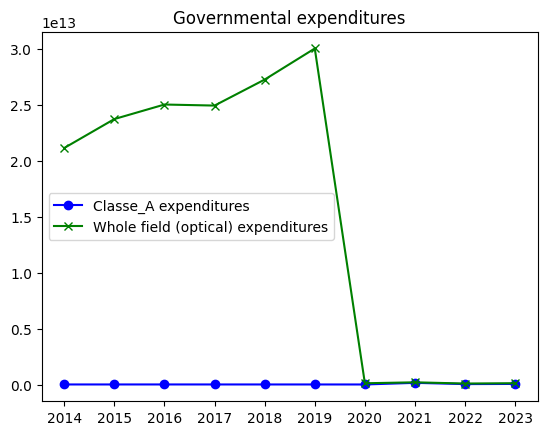

In [9]:
plt.plot(
    list(classe_A[0].keys()),
    list(classe_A[0].values()),
    color="blue",
    label="Classe_A expenditures",
    marker="o",
)
plt.plot(
    list(whole_optical[0].keys()),
    list(whole_optical[0].values()),
    color="green",
    label="Whole field (optical) expenditures",
    marker="x",
)

plt.xlabel = "Year"
plt.ylabel = "Amout (€)"

plt.legend()
plt.title(label="Governmental expenditures")
plt.show()

Need to be normalized, so we will be able to compare the trend.

In [10]:
from typing import List
import numpy as np


def normalized_by_mean(list: List[int]):
    normalized_list = []
    mean = np.mean(list)
    for int in list:
        int = int / mean
        normalized_list.append(int)

    return normalized_list


values_A = list(classe_A[0].values())
values_B = list(whole_optical[0].values())
values_A_LPP_codes = list(classe_A[1].values())
values_B_LPP_codes = list(whole_optical[1].values())

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


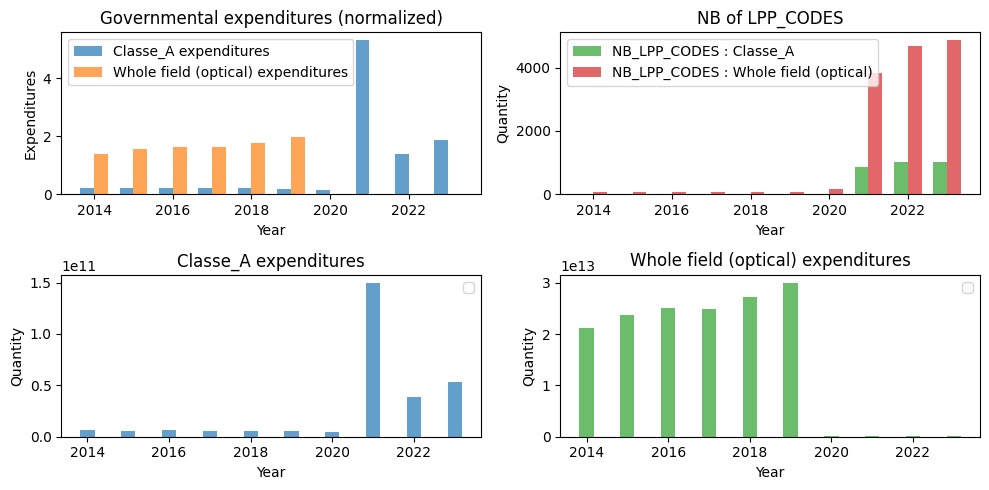

In [11]:
width = 0.35

fig, axes = plt.subplots(2, 2, figsize=(10, 5))

ax1, ax2 = axes[0, 0], axes[0, 1]
ax3, ax4 = axes[1, 0], axes[1, 1]

years_A = np.array([int(year) for year in classe_A[0].keys()])
years_B = np.array([int(year) for year in whole_optical[0].keys()])

ax1.bar(
    years_A - width / 2,
    normalized_by_mean(values_A),
    width=width,
    color="#1f77b4",
    label="Classe_A expenditures",
    alpha=0.7,
)
ax1.bar(
    years_B + width / 2,
    normalized_by_mean(values_B),
    width=width,
    color="#ff7f0e",
    label="Whole field (optical) expenditures",
    alpha=0.7,
)

ax1.set_title("Governmental expenditures (normalized)")
ax1.set_xlabel("Year")
ax1.set_ylabel("Expenditures")
ax1.legend()

years_A_LPP = np.array([int(year) for year in classe_A[1].keys()])
years_B_LPP = np.array([int(year) for year in whole_optical[1].keys()])

ax2.bar(
    years_A_LPP - width / 2,
    values_A_LPP_codes,
    width=width,
    color="#2ca02c",
    label="NB_LPP_CODES : Classe_A",
    alpha=0.7,
)
ax2.bar(
    years_B_LPP + width / 2,
    values_B_LPP_codes,
    width=width,
    color="#d62728",
    label="NB_LPP_CODES : Whole field (optical)",
    alpha=0.7,
)

ax2.set_title("NB of LPP_CODES")
ax2.set_xlabel("Year")
ax2.set_ylabel("Quantity")
ax2.legend()

ax3.bar(years_A_LPP, values_A, width=width, color="#1f77b4", alpha=0.7)

ax3.set_title("Classe_A expenditures")
ax3.set_xlabel("Year")
ax3.set_ylabel("Quantity")
ax3.legend()

ax4.bar(years_A_LPP, values_B, width=width, color="#2ca02c", alpha=0.7)

ax4.set_title("Whole field (optical) expenditures")
ax4.set_xlabel("Year")
ax4.set_ylabel("Quantity")
ax4.legend()

plt.tight_layout()
plt.show()

We can see that the government doesn't finance anymore the items who aren't in "Classe_A"

### DiD on code_LPP under 100% Santé (optical) plan and All fields' in LPP database (optical, hearing)

In [ ]:
importlib.reload(functions)
from functions import gov_exp

whole = gov_exp(inflation_adjustment=False, sector="all", mask={})

values_B = list(whole[0].values())
values_B_LPP_codes = list(whole[1].values())

In [ ]:
values_B_LPP_codes

In [ ]:
width = 0.35

fig, axes = plt.subplots(2, 2, figsize=(10, 5))

ax1, ax2 = axes[0, 0], axes[0, 1]
ax3, ax4 = axes[1, 0], axes[1, 1]

years_A = np.array([int(year) for year in classe_A[0].keys()])
years_B = np.array([int(year) for year in whole[0].keys()])

ax1.plot(
    years_A,
    normalized_by_mean(values_A),
    color="#1f77b4",
    label="Classe_A expenditures",
    alpha=0.7,
)
ax1.plot(
    years_B,
    normalized_by_mean(values_B),
    color="#ff7f0e",
    label="All fields' expenditures",
    alpha=0.7,
)

ax1.set_title("Governmental expenditures (normalized)")
ax1.set_xlabel("Year")
ax1.set_ylabel("Expenditures")
ax1.legend()

years_A_LPP = np.array([int(year) for year in classe_A[1].keys()])
years_B_LPP = np.array([int(year) for year in whole[1].keys()])

ax2.bar(
    years_A_LPP - width / 2,
    values_A_LPP_codes,
    width=width,
    color="#2ca02c",
    label="NB_LPP_CODES : Classe_A",
    alpha=0.7,
)
ax2.bar(
    years_B_LPP + width / 2,
    values_B_LPP_codes,
    width=width,
    color="#d62728",
    label="NB_LPP_CODES : All fields",
    alpha=0.7,
)

ax2.set_title("NB of LPP_CODES")
ax2.set_xlabel("Year")
ax2.set_ylabel("Quantity")
ax2.legend()

ax3.bar(years_A, values_A, width=width, color="#1f77b4", alpha=0.7)

ax3.set_title("Classe_A expenditures")
ax3.set_xlabel("Year")
ax3.set_ylabel("Expenditures")

ax4.bar(years_B, values_B, width=width, color="#ff7f0e", alpha=0.7)

ax4.set_title("All fields' expenditures")
ax4.set_xlabel("Year")
ax4.set_ylabel("Expenditures")

plt.tight_layout()
plt.show()

We see that, here, expenditures are not getting down at all, so we suppose that hearing field keep a certain amount of financement from government. We will verify it below.

### DiD on "classe I" expenditures and whole hearin field

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import copy
import json
import importlib
import functions

In [ ]:
importlib.reload(functions)

In [ ]:
classeI_hearing = gov_exp(
    inflation_adjustment=False,
    sector="hearing",
    mask={
        "AUDIOPROTHESES": ["contains", "L_SC1", "or"],
        "CLASSE I": ["contains", "L_CODE_LPP", "and"],
    },
)

In [ ]:
whole_hearing = gov_exp(
    inflation_adjustment=False,
    sector="hearing",
    mask={"AUDIOPROTHESES": ["contains", "L_SC1", "or"]},
)

In [ ]:
classeI_hearing

In [ ]:
whole_hearing

In [58]:
years_A = np.array([int(year) for year in classeI_hearing[0].keys()])
years_B = np.array([int(year) for year in whole_hearing[0].keys()])

values_A = list(classeI_hearing[0].values())
values_B = list(whole_hearing[0].values())

values_A_LPP_codes = classeI_hearing[1].values()
values_B_LPP_codes = whole_hearing[1].values()

In [59]:
from functions import normalized_by_mean

In [ ]:
width = 0.35

fig, axes = plt.subplots(2, 2, figsize=(10, 5))

ax1, ax2 = axes[0, 0], axes[0, 1]
ax3, ax4 = axes[1, 0], axes[1, 1]

ax1.plot(
    years_A,
    normalized_by_mean(values_A),
    color="#1f77b4",
    label="Classe_I expenditures",
    alpha=0.7,
)
ax1.plot(
    years_B,
    normalized_by_mean(values_B),
    color="#ff7f0e",
    label="Hearing expenditures",
    alpha=0.7,
)

ax1.set_title("Governmental expenditures (normalized)")
ax1.set_xlabel("Year")
ax1.set_ylabel("Expenditures")
ax1.legend()

ax2.bar(
    years_A - width / 2,
    values_A_LPP_codes,
    width=width,
    color="#2ca02c",
    label="NB_LPP_CODES : Classe_I",
    alpha=0.7,
)
ax2.bar(
    years_B + width / 2,
    values_B_LPP_codes,
    width=width,
    color="#d62728",
    label="NB_LPP_CODES : Hearing field",
    alpha=0.7,
)

ax2.set_title("NB of LPP_CODES")
ax2.set_xlabel("Year")
ax2.set_ylabel("Quantity")
ax2.legend()

ax3.bar(years_A, values_A, width=width, color="#1f77b4", alpha=0.7)

ax3.set_title("Classe_I expenditures")
ax3.set_xlabel("Year")
ax3.set_ylabel("Expenditures")

ax4.bar(years_B, values_B, width=width, color="#ff7f0e", alpha=0.7)

ax4.set_title("Hearing expenditures")
ax4.set_xlabel("Year")
ax4.set_ylabel("Expenditures")

plt.tight_layout()
plt.show()

## Brand comparison

### Hearing field

In [11]:
import json

with open("../data/potential_100Santé.json", "r", encoding="utf-8") as f:
    data = json.load(f)

In [12]:
# L_SC1 to keep, to get the brands informations that interest us
processeur = [
    "AIDE AUDITIVE POUR LES PERSONNES AU-DELA DE LEUR 20EME ANNIVERSAIRE",
    "AIDES AUDITIVES-PERSONNES <= 20 ANS OU PERSONNES ATTEINTES DE CECITE",
]
processeurs = [
    "AIDE AUDITIVE POUR LES PERSONNES AU-DELA DE LEUR 20EME ANNIVERSAIRE",
    "AIDES AUDITIVES-PERSONNES <= 20 ANS OU PERSONNES ATTEINTES DE CECITE",
]

In [13]:
interesting_keys = [
    "AUDIOPROTHESES ET ENTRETIEN, REPARATIONS ET ACCESSOIRES POUR PROCESSEUR",
    "AUDIOPROTHESES ET ENTRETIEN, REPARATIONS ET ACCESSOIRES POUR PROCESSEURS",
]
brands = []
count = 0

for key in interesting_keys:
    if count == 0:
        for sc1 in processeur:
            filtered = data[key][sc1]
            for element in filtered:
                parts = element.split(",")
                brand = parts[-1].strip()
                if brand in brands:
                    pass
                else:
                    brands.append(brand)
        count += 1
    else:
        for sc1 in processeurs:
            filtered = data[key][sc1]
            for element in filtered:
                parts = element.split(",")
                brand = parts[-1].strip()
                if brand in brands:
                    pass
                else:
                    brands.append(brand)
print(brands)

['> 20 ANS', 'STARKEY FRANCE', 'SONOVA FRANCE', 'PRODITION', 'WIDEX', 'SIVANTOS', 'GN HEARING SAS', 'BIOTONE TECH', '<= A 20 ANS', '<= 20 ANS', 'SUPERVISION SAS', 'MEDISOUND', 'SIGNIA', 'GAUCHE <= A 20 ANS']


In [14]:
brands_to_remove = [0, 8, 9, 13]
for number in sorted(brands_to_remove, reverse=True):
    del brands[number]
print(brands)

['STARKEY FRANCE', 'SONOVA FRANCE', 'PRODITION', 'WIDEX', 'SIVANTOS', 'GN HEARING SAS', 'BIOTONE TECH', 'SUPERVISION SAS', 'MEDISOUND', 'SIGNIA']


In [54]:
from functions import gov_exp

In [55]:
importlib.reload(functions)
import functions
from functions import gov_exp

In [54]:
brand_classI = []
for brand in brands:
    brand_ = brand.replace(" ", "_")
    variable = gov_exp(
        inflation_adjustment=False,
        sector="hearing",
        mask={
            "CLASSE I": ["contains", "L_CODE_LPP", "and"],
            str(brand): ["contains", "L_CODE_LPP", "and"],
        },
        indent=6,
    )
    brand_classI.append(variable)

2020
2020
key : 2020
2021
2021
key : 2021
2022
2022
key : 2022
2023
2023
key : 2023
2020
2020
key : 2020
2021
2021
key : 2021
2022
2022
key : 2022
2023
2023
key : 2023
2020
2020
key : 2020
2021
2021
key : 2021
2022
2022
key : 2022
2023
2023
key : 2023
2020
2020
key : 2020
2021
2021
key : 2021
2022
2022
key : 2022
2023
2023
key : 2023
2020
2020
key : 2020
2021
2021
key : 2021
2022
2022
key : 2022
2023
2023
key : 2023
2020
2020
key : 2020
2021
2021
key : 2021
2022
2022
key : 2022
2023
2023
key : 2023
2020
2020
key : 2020
2021
2021
key : 2021
2022
2022
key : 2022
2023
2023
key : 2023
2020
2020
key : 2020
2021
2021
key : 2021
2022
2022
key : 2022
2023
2023
key : 2023
2020
2020
key : 2020
2021
2021
key : 2021
2022
2022
key : 2022
2023
2023
key : 2023
2020
2020
key : 2020
2021
2021
key : 2021
2022
2022
key : 2022
2023
2023
key : 2023


In [66]:
brand_classI

[({'2020': 0.0,
   '2021': 6039094965.379999,
   '2022': 10117942719.7,
   '2023': 19626629494.440002},
  {'2020': 0, '2021': 4, '2022': 4, '2023': 4},
  {'2020': 0, '2021': 55541, '2022': 68710, '2023': 77221}),
 ({'2020': 0.0,
   '2021': 12779776580.05,
   '2022': 31574435544.78,
   '2023': 25082190939.51},
  {'2020': 0, '2021': 4, '2022': 4, '2023': 4},
  {'2020': 0, '2021': 76956, '2022': 124220, '2023': 109469}),
 ({'2020': 0.0,
   '2021': 28633914728.96,
   '2022': 24680360274.15,
   '2023': 16795411609.8},
  {'2020': 0, '2021': 4, '2022': 4, '2023': 4},
  {'2020': 0, '2021': 114365, '2022': 111562, '2023': 94312}),
 ({'2020': 0.0,
   '2021': 1612273609.05,
   '2022': 2131438338.6000001,
   '2023': 1168481743.0},
  {'2020': 0, '2021': 4, '2022': 4, '2023': 4},
  {'2020': 0, '2021': 27188, '2022': 31681, '2023': 23322}),
 ({'2020': 0.0,
   '2021': 9357485650.56,
   '2022': 10914560624.17,
   '2023': 10965084823.48},
  {'2020': 0, '2021': 4, '2022': 4, '2023': 4},
  {'2020': 0, '20

In [67]:
count = 0
classI_brands_json = {}
for brand in brands:
    classI_brands_json[brand] = brand_classI[count]
    count += 1

classI_brands_json

{'STARKEY FRANCE': ({'2020': 0.0,
   '2021': 6039094965.379999,
   '2022': 10117942719.7,
   '2023': 19626629494.440002},
  {'2020': 0, '2021': 4, '2022': 4, '2023': 4},
  {'2020': 0, '2021': 55541, '2022': 68710, '2023': 77221}),
 'SONOVA FRANCE': ({'2020': 0.0,
   '2021': 12779776580.05,
   '2022': 31574435544.78,
   '2023': 25082190939.51},
  {'2020': 0, '2021': 4, '2022': 4, '2023': 4},
  {'2020': 0, '2021': 76956, '2022': 124220, '2023': 109469}),
 'PRODITION': ({'2020': 0.0,
   '2021': 28633914728.96,
   '2022': 24680360274.15,
   '2023': 16795411609.8},
  {'2020': 0, '2021': 4, '2022': 4, '2023': 4},
  {'2020': 0, '2021': 114365, '2022': 111562, '2023': 94312}),
 'WIDEX': ({'2020': 0.0,
   '2021': 1612273609.05,
   '2022': 2131438338.6000001,
   '2023': 1168481743.0},
  {'2020': 0, '2021': 4, '2022': 4, '2023': 4},
  {'2020': 0, '2021': 27188, '2022': 31681, '2023': 23322}),
 'SIVANTOS': ({'2020': 0.0,
   '2021': 9357485650.56,
   '2022': 10914560624.17,
   '2023': 10965084823.4

In [70]:
def convert_to_native(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        raise TypeError(f"Type {type(obj)} not serializable")

In [71]:
with open(
    "../data/classI_gov_exp_for_different_brands_hearing_field", "w", encoding="utf-8"
) as f:
    json.dump(
        classI_brands_json, f, ensure_ascii=False, indent=4, default=convert_to_native
    )

In [72]:
brand_classII = []
for brand in brands:
    brand_ = brand.replace(" ", "_")
    variable = gov_exp(
        inflation_adjustment=False,
        sector="hearing",
        mask={
            "CLASSE II": ["contains", "L_CODE_LPP", "and"],
            str(brand): ["contains", "L_CODE_LPP", "and"],
        },
        indent=6,
    )
    brand_classII.append(variable)

2020
2020
key : 2020
2021
2021
key : 2021
2022
2022
key : 2022
2023
2023
key : 2023
2020
2020
key : 2020
2021
2021
key : 2021
2022
2022
key : 2022
2023
2023
key : 2023
2020
2020
key : 2020
2021
2021
key : 2021
2022
2022
key : 2022
2023
2023
key : 2023
2020
2020
key : 2020
2021
2021
key : 2021
2022
2022
key : 2022
2023
2023
key : 2023
2020
2020
key : 2020
2021
2021
key : 2021
2022
2022
key : 2022
2023
2023
key : 2023
2020
2020
key : 2020
2021
2021
key : 2021
2022
2022
key : 2022
2023
2023
key : 2023
2020
2020
key : 2020
2021
2021
key : 2021
2022
2022
key : 2022
2023
2023
key : 2023
2020
2020
key : 2020
2021
2021
key : 2021
2022
2022
key : 2022
2023
2023
key : 2023
2020
2020
key : 2020
2021
2021
key : 2021
2022
2022
key : 2022
2023
2023
key : 2023
2020
2020
key : 2020
2021
2021
key : 2021
2022
2022
key : 2022
2023
2023
key : 2023


In [74]:
count = 0
classII_brands_json = {}
for brand in brands:
    classII_brands_json[brand] = brand_classII[count]
    count += 1

with open(
    "../data/classII_gov_exp_for_different_brands_hearing_field", "w", encoding="utf-8"
) as f:
    json.dump(
        classII_brands_json, f, ensure_ascii=False, indent=4, default=convert_to_native
    )

In [75]:
import json

with open(
    "../data/classI_gov_exp_for_different_brands_hearing_field", "r", encoding="utf-8"
) as f:
    dataC1 = json.load(f)

with open(
    "../data/classII_gov_exp_for_different_brands_hearing_field", "r", encoding="utf-8"
) as f:
    dataC2 = json.load(f)

In [76]:
list_years = np.array([int(year) for year in dataC1["STARKEY FRANCE"][0].keys()])

In [77]:
list_years

array([2020, 2021, 2022, 2023])

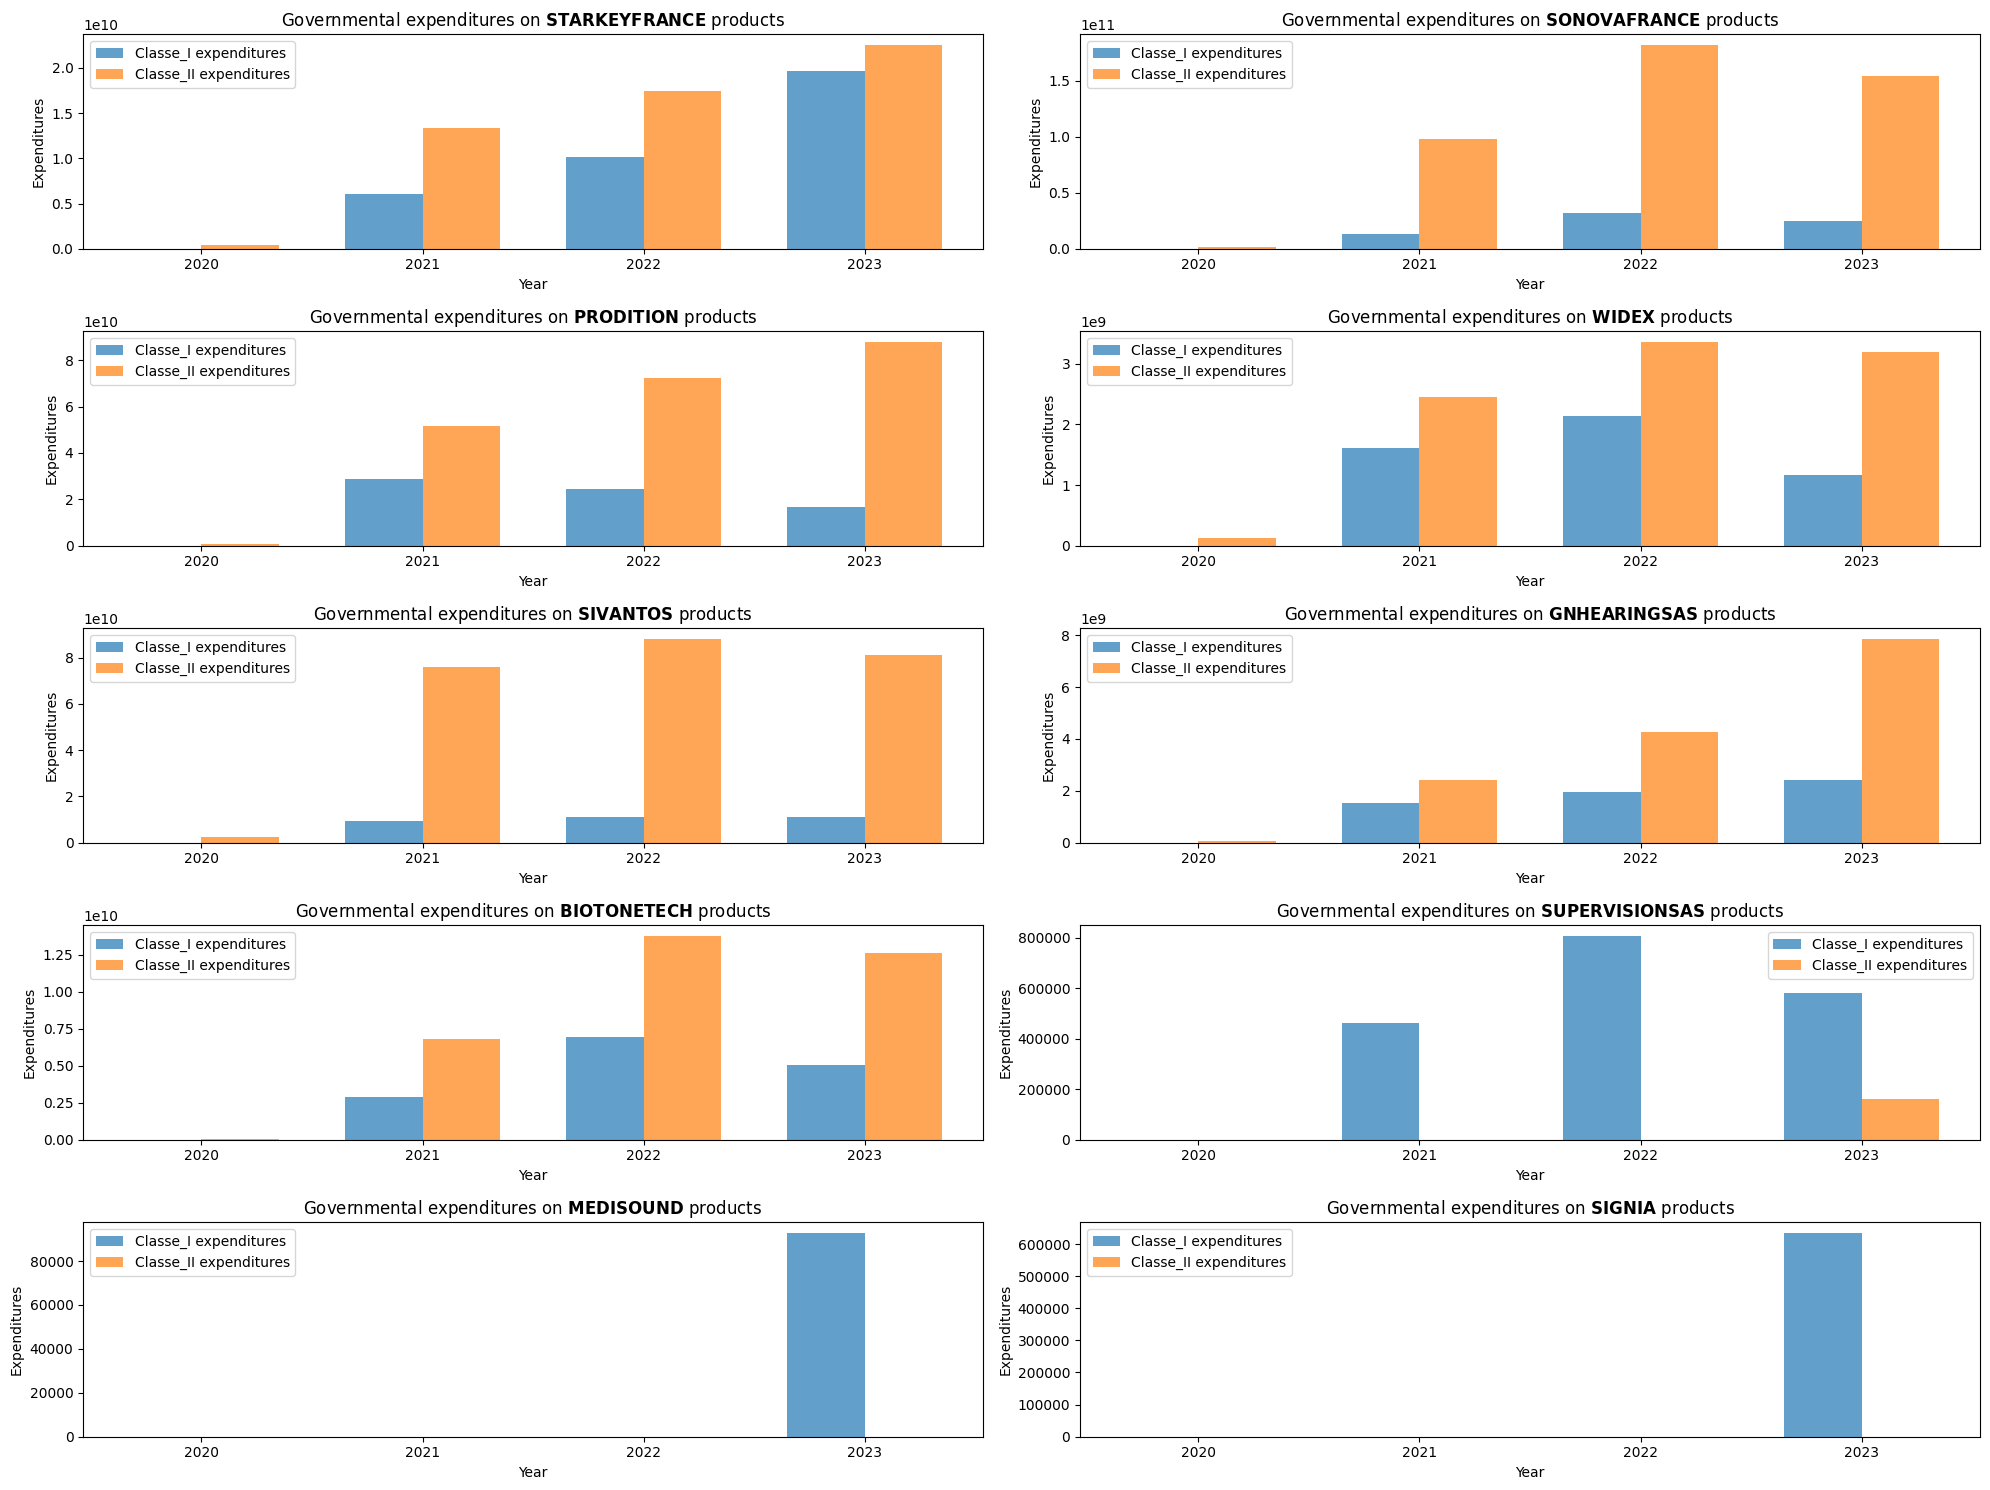

In [86]:
width = 0.35

fig, axes = plt.subplots(5, 2, figsize=(20, 15))

axes = axes.flatten()

count = 0

for brand in brands:

    axe = axes[count]
    axe.bar(
        list_years - width / 2,
        dataC1[brand][0].values(),
        width=width,
        color="#1f77b4",
        label=f"Classe_I expenditures",
        alpha=0.7,
    )
    axe.bar(
        list_years + width / 2,
        dataC2[brand][0].values(),
        width=width,
        color="#ff7f0e",
        label=f"Classe_II expenditures",
        alpha=0.7,
    )

    axe.set_title(f"Governmental expenditures on $\\mathbf{{{brand}}}$ products")
    axe.set_xlabel("Year")
    axe.set_ylabel("Expenditures")
    axe.legend()

    axe.set_xticks(
        list_years
    )  # Assure que seules les années entières sont utilisées comme labels
    # axe.set_xticklabels([str(int(year)) for year in list_years])  # Affiche les années entières

    count += 1

    plt.tight_layout()

plt.show()

we need to take a look at the number of refunds, to see if people tends to get class I or II.

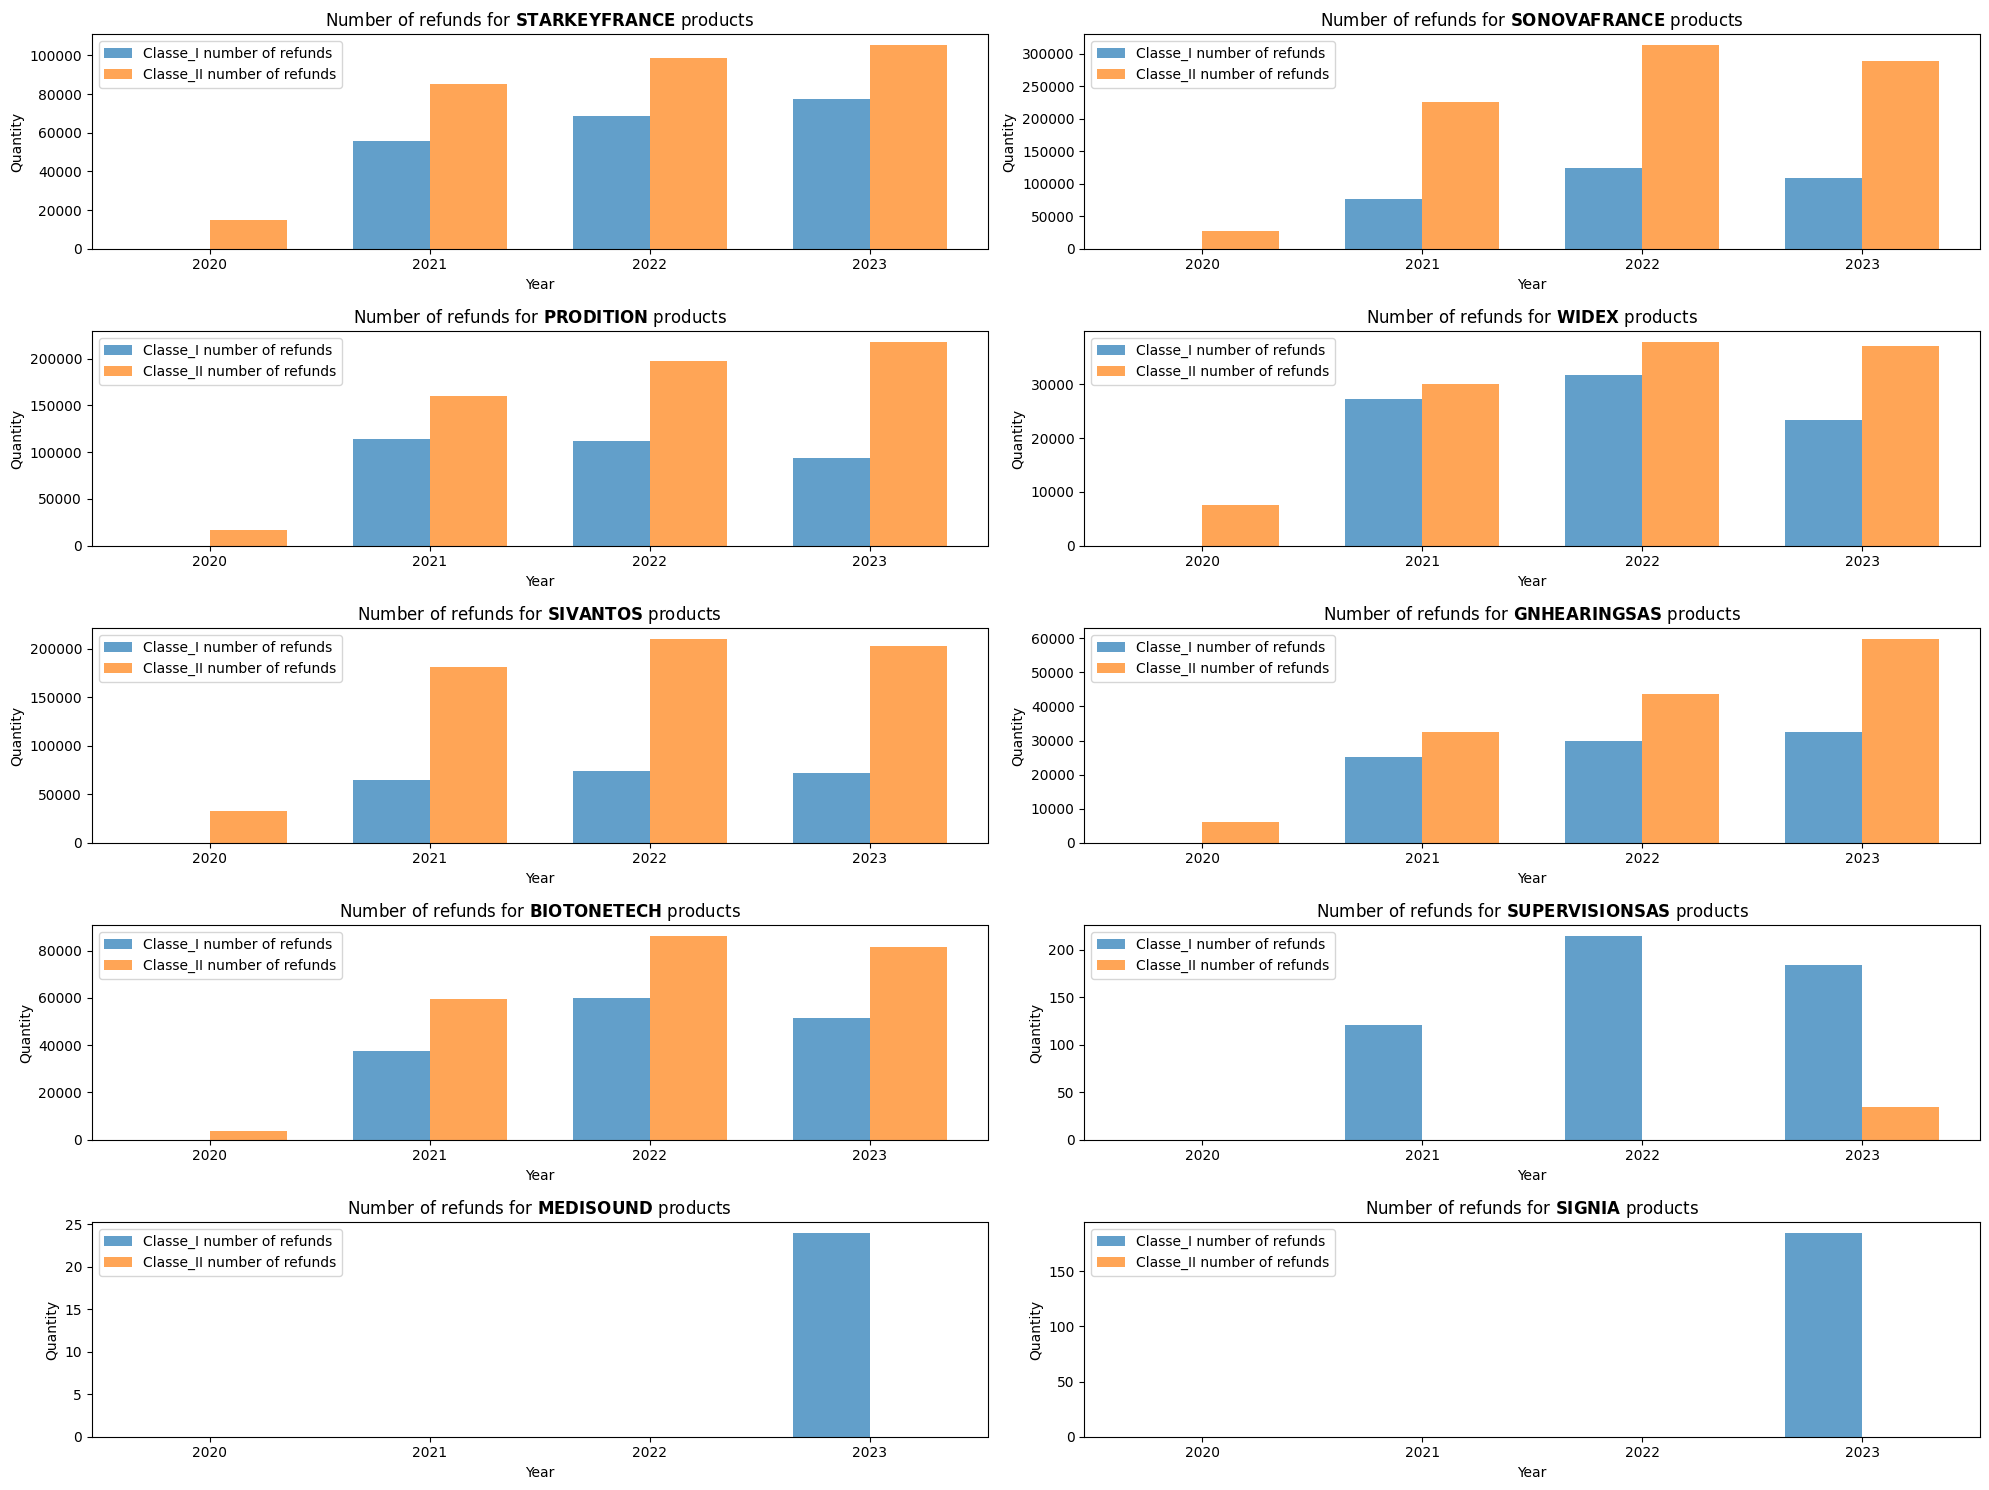

In [88]:
fig, axes = plt.subplots(5, 2, figsize=(20, 15))

axes = axes.flatten()

count = 0

for brand in brands:

    axe = axes[count]
    axe.bar(
        list_years - width / 2,
        dataC1[brand][2].values(),
        width=width,
        color="#1f77b4",
        label=f"Classe_I number of refunds",
        alpha=0.7,
    )
    axe.bar(
        list_years + width / 2,
        dataC2[brand][2].values(),
        width=width,
        color="#ff7f0e",
        label=f"Classe_II number of refunds",
        alpha=0.7,
    )

    axe.set_title(f"Number of refunds for $\\mathbf{{{brand}}}$ products")
    axe.set_xlabel("Year")
    axe.set_ylabel("Quantity")
    axe.legend()

    axe.set_xticks(list_years)  # ensure that only entire years are used as labels

    count += 1

    plt.tight_layout()

plt.show()

### Optical field

In [5]:
with open("../data/potential_100Santé.json", "r") as f:
    data = json.load(f)

In [6]:
optical_brands = []
digits = "0123456789"
keywords = ["VERRE", "ADULTE", "ENFANT"]

for element in data["OPTIQUE MEDICALE"]["LUNETTES"]:
    parts = element.split(",")
    brand = parts[-1].strip()
    if any(keyword in brand for keyword in keywords) or any(
        digit in brand for digit in digits
    ):
        pass
    else:
        if brand in optical_brands:
            pass
        else:
            optical_brands.append(brand)

print(len(optical_brands))
print(optical_brands)

729
['LAFONT', 'MARIUS MOREL', 'LUXOTTICA', 'VICTOR GROS', 'GROSFILLEY', 'OCTIKA', 'BEAUSOLEIL', 'MYKITA', 'DO FRANCE', 'VOTRE OPTICIEN', 'NAKO', 'JIMMY FAIRLY', 'OPTIC COLIN', 'VGI', 'SPOROPTIC', 'BOLD', 'OPTISWISS', 'OPTIC VALLEY', 'LE PETIT LUNETIER', 'DR EUGEN BECK', 'LAYER AGENCY', 'STOCK', 'LUNETTES VISAGE', 'LOU CREATION', 'CENTRAL VISION', 'GBO PRO', 'EYE FIVE COMP', 'ALAIN AFFLELOU', 'MENRAD SA', 'VINTAGE LAB', 'LUNETTE PR TOUS', 'ALLURE EYEW.', 'NEW TIME', 'OPTILENSES', 'SHINETIME', 'ACHD', 'AM EYEWEAR', 'ATELIER LUCAS', 'AU', 'BEL OPTIC', 'CCS LUNETTERIE', 'DAVIDE FICHERA', 'E.H.V.M', 'ETAB GOUV AUDI', 'EYE SPECIALS', "EYE'S HEAVEN", 'EYEVAN EUROPE', 'EYEWEAR DESIGNS', 'G.A.YELLOWS', 'GARRETT LEIGHT', 'JAA OPTIQUE', 'JLE OPTIQUE', 'JOLY JP LTD', 'JUST ET O', 'LA LUNETTERIE', 'LEGENDRE', 'LENTIS GROUP', 'M. MARUYAMA', 'MANUFACT LUNET', 'MIMOUNI', 'MIOPTICO FRANCE', 'MIZE', 'MOU COMPANY', 'NEA OPTIKI', 'OKO OPTICAL', "OPTI'BUDGET", 'OPTIC PACHECO', 'OPTICUNION', 'PACIFIC BLEU'

In [7]:
keywords = ["ESSILOR", "SAFILO", "ALAIN", "MARIUS", "JIMMY"]
five_international_optical_brands = []

for brand in optical_brands:
    if any(keyword in brand for keyword in keywords):
        five_international_optical_brands.append(brand)

five_international_optical_brands

['MARIUS MOREL', 'JIMMY FAIRLY', 'ALAIN AFFLELOU', 'SAFILO-FRANCE', 'ESSILOR']

In [8]:
keywords = ["ALAIN", "AMY", "HENRY", "MOREL", "ROUSSILHE", "OPAL", "PETIT", "JIMMY"]
ten_french_optical_brands = []

for brand in optical_brands:
    if any(keyword in brand for keyword in keywords):
        ten_french_optical_brands.append(brand)

ten_french_optical_brands.pop(-2)
ten_french_optical_brands.pop(-2)
ten_french_optical_brands.pop(2)
ten_french_optical_brands.pop(-3)
ten_french_optical_brands

['MARIUS MOREL',
 'JIMMY FAIRLY',
 'ALAIN AFFLELOU',
 'OPAL',
 "L'AMY",
 'HENRY JULLIEN',
 'PETIT LUNETIER',
 'ROUSSILHE']

More than 700 brands in the optical field, I think we should take the most famous of them in order to get some details and interesting conclusions.

This is what it's done above, we took the ten most famous brands in the world, and the same criter in France for the second list.

#### class A, french brands

In [14]:
from functions import gov_exp

In [15]:
french_brand_classA = []
for brand in ten_french_optical_brands:
    variable = gov_exp(
        inflation_adjustment=False,
        sector="optical",
        mask={
            "CLASSE A": ["contains", "L_CODE_LPP", "and"],
            str(brand): ["contains", "L_CODE_LPP", "and"],
        },
        indent=6,
    )
    french_brand_classA.append(variable)

In [16]:
count = 0
french_classA_brands_json = {}
for brand in ten_french_optical_brands:
    french_classA_brands_json[brand] = french_brand_classA[count]
    count += 1

In [17]:
from functions import convert_to_native

In [18]:
with open(
    "../data/classA_gov_exp_for_different_french_brands_optical_field",
    "w",
    encoding="utf-8",
) as f:
    json.dump(
        french_classA_brands_json,
        f,
        ensure_ascii=False,
        indent=4,
        default=convert_to_native,
    )

#### class A, international brands

In [18]:
from functions import gov_exp

In [19]:
international_brand_classA = []
for brand in five_international_optical_brands:
    variable = gov_exp(
        inflation_adjustment=False,
        sector="optical",
        mask={
            "CLASSE A": ["contains", "L_CODE_LPP", "and"],
            str(brand): ["contains", "L_CODE_LPP", "and"],
        },
        indent=6,
    )
    international_brand_classA.append(variable)

In [20]:
count = 0
international_classA_brands_json = {}
for brand in five_international_optical_brands:
    international_classA_brands_json[brand] = international_brand_classA[count]
    count += 1

In [21]:
from functions import convert_to_native

In [22]:
with open(
    "../data/classA_gov_exp_for_different_international_brands_optical_field",
    "w",
    encoding="utf-8",
) as f:
    json.dump(
        international_classA_brands_json,
        f,
        ensure_ascii=False,
        indent=4,
        default=convert_to_native,
    )

#### french brands

In [23]:
from functions import gov_exp

In [24]:
french_brand = []
for brand in ten_french_optical_brands:
    variable = gov_exp(
        inflation_adjustment=False,
        sector="optical",
        mask={str(brand): ["contains", "L_CODE_LPP", "and"]},
        indent=6,
    )
    french_brand.append(variable)

In [25]:
count = 0
french_brands_json = {}
for brand in ten_french_optical_brands:
    french_brands_json[brand] = french_brand[count]
    count += 1

In [26]:
from functions import convert_to_native

In [27]:
with open(
    "../data/gov_exp_for_different_french_brands_optical_field", "w", encoding="utf-8"
) as f:
    json.dump(
        french_brands_json, f, ensure_ascii=False, indent=4, default=convert_to_native
    )

#### international brands

In [29]:
international_brand = []
for brand in five_international_optical_brands:
    variable = gov_exp(
        inflation_adjustment=False,
        sector="optical",
        mask={str(brand): ["contains", "L_CODE_LPP", "or"]},
        indent=6,
    )
    international_brand.append(variable)

In [30]:
count = 0
international_brands_json = {}
for brand in five_international_optical_brands:
    international_brands_json[brand] = international_brand[count]
    count += 1

In [31]:
from functions import convert_to_native

In [32]:
with open(
    "../data/gov_exp_for_different_international_brands_optical_field",
    "w",
    encoding="utf-8",
) as f:
    json.dump(
        international_brands_json,
        f,
        ensure_ascii=False,
        indent=4,
        default=convert_to_native,
    )

## Before/After comparison

### hearing

In [36]:
classA = gov_exp(
    inflation_adjustment=False,
    sector="hearing",
    mask={
        "AUDIOPROTHESES": ["contains", "L_SC1", "and"],
        "CLASSE A": ["contains", "L_CODE_LPP", "and"],
    },
    indent=0,
)

In [37]:
classB = gov_exp(
    inflation_adjustment=False,
    sector="hearing",
    mask={
        "AUDIOPROTHESES": ["contains", "L_SC1", "and"],
        "CLASSE B": ["contains", "L_CODE_LPP", "and"],
    },
    indent=0,
)

In [38]:
classC = gov_exp(
    inflation_adjustment=False,
    sector="hearing",
    mask={
        "AUDIOPROTHESES": ["contains", "L_SC1", "and"],
        "CLASSE C": ["contains", "L_CODE_LPP", "and"],
    },
    indent=0,
)

In [39]:
classD = gov_exp(
    inflation_adjustment=False,
    sector="hearing",
    mask={
        "AUDIOPROTHESES": ["contains", "L_SC1", "and"],
        "CLASSE D": ["contains", "L_CODE_LPP", "and"],
    },
    indent=0,
)

In [51]:
classD

[{'2014': 90563560.72999999,
  '2015': 101591178.9,
  '2016': 107455252.05,
  '2017': 113538367.48,
  '2018': 123048793.42000002,
  '2019': 7427900.1,
  '2020': 94315.19,
  '2021': 18574.57,
  '2022': 0.0,
  '2023': 6524.87},
 {'2014': 2,
  '2015': 2,
  '2016': 2,
  '2017': 2,
  '2018': 2,
  '2019': 2,
  '2020': 2,
  '2021': 2,
  '2022': 0,
  '2023': 1},
 {'2014': 534560,
  '2015': 615913,
  '2016': 660904,
  '2017': 715688,
  '2018': 773848,
  '2019': 46907,
  '2020': 635,
  '2021': 56,
  '2022': 0,
  '2023': 20}]

In [52]:
from collections import Counter

In [42]:
dict1 = {"2014": 1, "2015": 1}

dict2 = {"2014": 3, "2015": 2}

counter = dict(Counter(dict1) + Counter(dict2))

In [43]:
counter

{'2014': 4, '2015': 3}

In [73]:
from collections import Counter, defaultdict

classABCD = []

for i in range(3):
    combined = defaultdict(int)

    # Ajouter les valeurs de classA, classB, classC, classD
    for key, value in Counter(classA[i]).items():
        combined[key] += value
    for key, value in Counter(classB[i]).items():
        combined[key] += value
    for key, value in Counter(classC[i]).items():
        combined[key] += value
    for key, value in Counter(classD[i]).items():
        combined[key] += value

    # Ajouter le dictionnaire combiné à la liste
    classABCD.append(dict(combined))

# Afficher le résultat
print(classABCD)

[{'2014': 94260371.69999999, '2015': 104553781.60000001, '2016': 109512155.66, '2017': 115178323.61, '2018': 125058999.39000002, '2019': 7534229.949999999, '2020': 95086.54000000001, '2021': 18574.57, '2022': 0.0, '2023': 6524.87}, {'2014': 7, '2015': 8, '2016': 7, '2017': 7, '2018': 7, '2019': 5, '2020': 4, '2021': 2, '2022': 0, '2023': 1}, {'2014': 561975, '2015': 638570, '2016': 677147, '2017': 729004, '2018': 789416, '2019': 47858, '2020': 663, '2021': 56, '2022': 0, '2023': 20}]


In [59]:
classI = gov_exp(
    inflation_adjustment=False,
    sector="hearing",
    mask={
        "AUDIOPROTHESES": ["contains", "L_SC1", "and"],
        "CLASSE I": ["contains", "L_CODE_LPP", "and"],
    },
    indent=0,
)

In [60]:
classI

[{'2014': 0.0,
  '2015': 0.0,
  '2016': 0.0,
  '2017': 0.0,
  '2018': 0.0,
  '2019': 48852.0,
  '2020': 8496.0,
  '2021': 126506259.38,
  '2022': 130955650.46000001,
  '2023': 121066130.66999999},
 {'2014': 0,
  '2015': 0,
  '2016': 0,
  '2017': 0,
  '2018': 0,
  '2019': 2,
  '2020': 2,
  '2021': 34,
  '2022': 33,
  '2023': 36},
 {'2014': 0,
  '2015': 0,
  '2016': 0,
  '2017': 0,
  '2018': 0,
  '2019': 216,
  '2020': 32,
  '2021': 487071,
  '2022': 500338,
  '2023': 460234}]

In [61]:
classII = gov_exp(
    inflation_adjustment=False,
    sector="hearing",
    mask={
        "AUDIOPROTHESES": ["contains", "L_SC1", "and"],
        "CLASSE II": ["contains", "L_CODE_LPP", "and"],
    },
    indent=0,
)

In [62]:
classII

[{'2014': 0.0,
  '2015': 0.0,
  '2016': 0.0,
  '2017': 0.0,
  '2018': 0.0,
  '2019': 144016216.38,
  '2020': 182223684.03000003,
  '2021': 261780452.1,
  '2022': 272030311.51,
  '2023': 274981872.34000003},
 {'2014': 0,
  '2015': 0,
  '2016': 0,
  '2017': 0,
  '2018': 0,
  '2019': 4,
  '2020': 32,
  '2021': 32,
  '2022': 32,
  '2023': 34},
 {'2014': 0,
  '2015': 0,
  '2016': 0,
  '2017': 0,
  '2018': 0,
  '2019': 681752,
  '2020': 751988,
  '2021': 970289,
  '2022': 989138,
  '2023': 995075}]

In [80]:
classI_II = []

for i in range(3):
    combined = defaultdict(int)

    # Ajouter les valeurs de classA, classB, classC, classD
    for key, value in Counter(classI[i]).items():
        combined[key] += value
    for key, value in Counter(classII[i]).items():
        combined[key] += value

    # Ajouter le dictionnaire combiné à la liste
    classI_II.append(dict(combined))

# Afficher le résultat
print(classI_II)

[{'2014': 0.0, '2015': 0.0, '2016': 0.0, '2017': 0.0, '2018': 0.0, '2019': 144065068.38, '2020': 182232180.03000003, '2021': 388286711.48, '2022': 402985961.97, '2023': 396048003.01}, {'2014': 0, '2015': 0, '2016': 0, '2017': 0, '2018': 0, '2019': 6, '2020': 34, '2021': 66, '2022': 65, '2023': 70}, {'2014': 0, '2015': 0, '2016': 0, '2017': 0, '2018': 0, '2019': 681968, '2020': 752020, '2021': 1457360, '2022': 1489476, '2023': 1455309}]


In [63]:
list_years = np.array([year for year in classII[0].keys()])

array(['2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021',
       '2022', '2023'], dtype='<U4')

In [72]:
classABCD[0]

{'2014': 94260371.69999999,
 '2015': 104553781.60000001,
 '2016': 109512155.66,
 '2017': 115178323.61,
 '2018': 125058999.39000002,
 '2019': 7534229.949999999,
 '2020': 95086.54000000001,
 '2021': 18574.57,
 '2023': 6524.87}

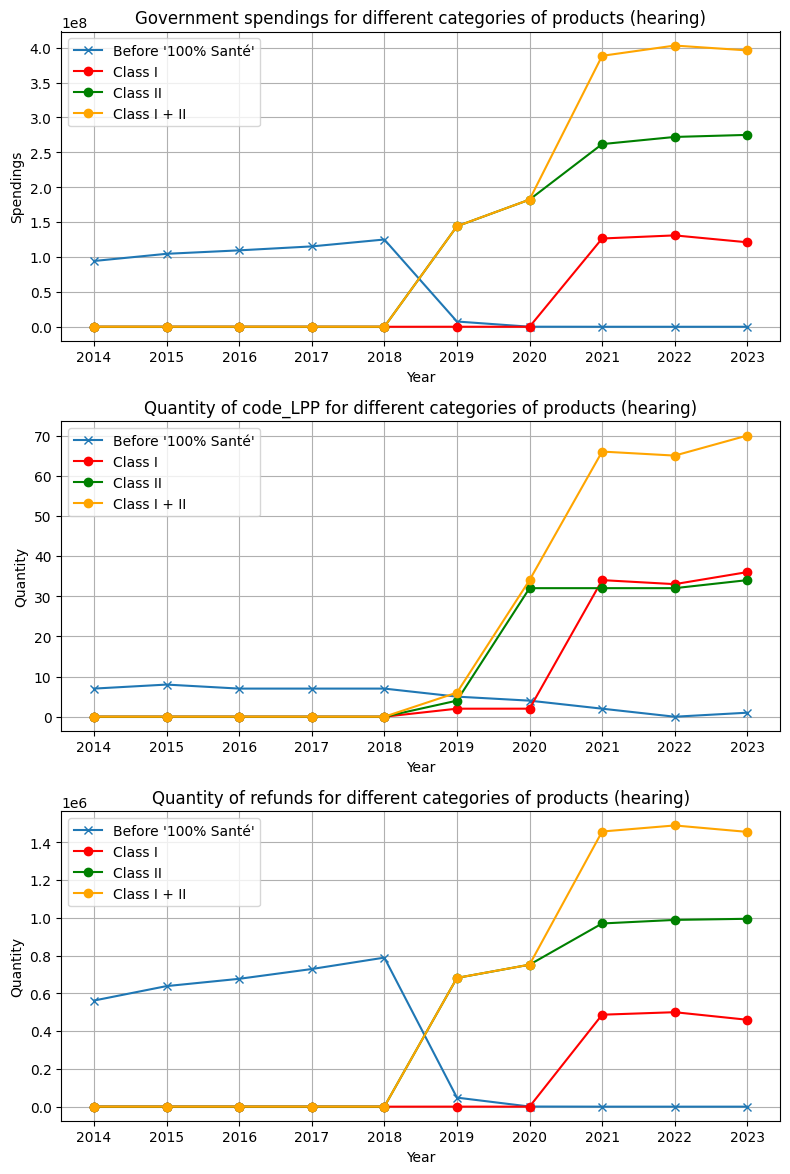

In [91]:
fig, axes = plt.subplots(3, 1, figsize=(8, 12))

axes = axes.flatten()

for i in range(3):
    axes[i].plot(
        list_years,
        classABCD[i].values(),
        color="#1f77b4",
        label="Before '100% Santé'",
        marker="x",
    )
    axes[i].plot(
        list_years, classI[i].values(), color="red", label="Class I", marker="o"
    )
    axes[i].plot(
        list_years, classII[i].values(), color="green", label="Class II", marker="o"
    )
    axes[i].plot(
        list_years,
        classI_II[i].values(),
        color="orange",
        label="Class I + II",
        marker="o",
    )
    axes[i].set_xlabel("Year")
    axes[i].set_xticks(list_years)

axes[0].set_title("Government spendings for different categories of products (hearing)")
axes[0].set_ylabel("Spendings")

axes[1].set_title("Quantity of code_LPP for different categories of products (hearing)")
axes[1].set_ylabel("Quantity")

axes[2].set_title("Quantity of refunds for different categories of products (hearing)")
axes[2].set_ylabel("Quantity")

for i in range(3):
    axes[i].grid()
    axes[i].legend()

plt.tight_layout()
plt.show()

### optical

In [18]:
importlib.reload(functions)
from functions import gov_exp

In [88]:
classA_m_o = gov_exp(
    inflation_adjustment=True,
    sector="optical",
    mask={
        "OPTIQUE": ["contains", "L_SC1", "and"],
        "MONTURE": ["contains", "L_CODE_LPP", "and"],
        "CLASSE A": ["contains", "L_CODE_LPP", "and"],
    },
    indent=0,
)

In [89]:
len(classA_m_o)

5

In [91]:
classA_v_o = gov_exp(
    inflation_adjustment=True,
    sector="optical",
    mask={
        "OPTIQUE": ["contains", "L_SC1", "and"],
        "VERRE": ["contains", "L_CODE_LPP", "and"],
        "CLASSE A": ["contains", "L_CODE_LPP", "and"],
    },
    indent=0,
)

In [92]:
m_o = gov_exp(
    inflation_adjustment=True,
    sector="optical",
    mask={
        "OPTIQUE": ["contains", "L_SC1", "and"],
        "MONTURE": ["contains", "L_CODE_LPP", "and"],
    },
    indent=0,
)

In [93]:
v_o = gov_exp(
    inflation_adjustment=True,
    sector="optical",
    mask={
        "OPTIQUE": ["contains", "L_SC1", "and"],
        "VERRE": ["contains", "L_CODE_LPP", "and"],
    },
    indent=0,
)

In [94]:
vs_o = gov_exp(
    inflation_adjustment=True,
    sector="optical",
    mask={
        "OPTIQUE": ["contains", "L_SC1", "and"],
        "VERRES": ["contains", "L_CODE_LPP", "and"],
    },
    indent=0,
)

In [95]:
for i in range(4):
    for key in v_o[0].keys():
        v_o[i][key] = vs_o[i][key] + v_o[i][key]

In [96]:
m_o_noA = [{} for _ in range(len(v_o))]
v_o_noA = [{} for _ in range(len(v_o))]

for i in range(len(v_o)):
    for key in v_o[0].keys():
        m_o_noA[i][key] = m_o[i][key] - classA_m_o[i][key]
        v_o_noA[i][key] = v_o[i][key] - classA_v_o[i][key]

We see that class A frames "completely" disappears whereas class A glasses don't have the same success.

In [97]:
from functions import convert_to_native

In [98]:
with open("../data/results/gov_exp_classA_frames.json", "w", encoding="utf-8") as f:
    json.dump(classA_m_o, f, ensure_ascii=False, indent=4, default=convert_to_native)

In [99]:
with open("../data/results/gov_exp_classA_glasses.json", "w", encoding="utf-8") as f:
    json.dump(classA_v_o, f, ensure_ascii=False, indent=4, default=convert_to_native)

In [100]:
with open("../data/results/gov_exp_'VERRE(S)'.json", "w", encoding="utf-8") as f:
    json.dump(v_o, f, ensure_ascii=False, indent=4, default=convert_to_native)

In [101]:
with open("../data/results/gov_exp_'MONTURE'.json", "w", encoding="utf-8") as f:
    json.dump(m_o, f, ensure_ascii=False, indent=4, default=convert_to_native)

In [102]:
with open(
    "../data/results/gov_exp_'VERRE(S)'_noclassA.json", "w", encoding="utf-8"
) as f:
    json.dump(v_o_noA, f, ensure_ascii=False, indent=4, default=convert_to_native)

In [103]:
with open(
    "../data/results/gov_exp_'MONTURE'_noclassA.json", "w", encoding="utf-8"
) as f:
    json.dump(m_o_noA, f, ensure_ascii=False, indent=4, default=convert_to_native)

finding group control for optical BSE

In [19]:
optical = gov_exp(
    inflation_adjustment=True,
    sector="optical",
    mask={"OPTIQUE": ["contains", "L_SC1", "and"]},
    indent=0,
)

In [55]:
experimental_group = optical[4]["2019"] - optical[4]["2014"]
experimental_group

62085138.25999999

In [56]:
with open("../data/results/L_SC1_SC2_LPP_gov_exp_raw.json", "r", encoding="utf-8") as f:
    titles = json.load(f)

In [57]:
len(titles)
print(titles.keys())

dict_keys(['DM, MATERIELS ET PRODUITS POUR LE TRAITEMENT DE PATHOLOGIES SPECIFIQUES', 'DM DE MAINTIEN A DOMICILE ET D AIDE A LA VIE POUR MALADES ET HANDICAPE', 'ARTICLES POUR PANSEMENTS, MATERIELS DE CONTENTION', 'ACCESSOIRES DE PRODUITS INSCRITS AU TITRE III', 'CODES ARRIVES A ECHEANCE', 'ORTHESES', 'OPTIQUE MEDICALE', 'AUDIOPROTHESES ET ENTRETIEN, REPARATIONS ET ACCESSOIRES POUR PROCESSEUR', 'PROTHESES EXTERNES NON ORTHOPEDIQUES', 'PROTHESES OCULAIRES ET FACIALES', 'PODO-ORTHESES', 'DMI D ORIGINE SYNTHETIQUE', 'DMI ISSUS DE DERIVES ORIGINE ANIMALE NON VIABLES OU EN COMPORTANT', 'IMPLANTS ISSUS DE DERIVES HUMAINS-GREFFONS', 'DISPOSITIFS MEDICAUX IMPLANTABLES ACTIFS', 'FAUTEUILS ROULANTS', 'VEHICULES DIVERS', 'ADJONCTIONS, OPTIONS ET REPARATIONS APPLICABLES AUX FAUTEUILS ROULANTS', 'APPAREIL GENERATEUR D AEROSOL', 'ORTHESES (PETIT APPAREILLAGE) (CHAP.1)', 'ORTHOPROTHESES(CHAP.7)', 'DISPOSITIFS MEDICAUX UTILISES DANS LE SYST CARDIO-VASCULAIRE', 'DISPOSITIFS MEDICAUX UTILISES EN NEUROLOG

In [58]:
test = pd.read_csv(
    "../Open-LPP-data/base_complete/OPEN_LPP_2014.CSV", encoding="ISO-8859-1", sep=";"
)
test.columns

Index(['TITRE', 'L_TITRE', 'sc1', 'L_SC1', 'sc2', 'L_SC2', 'CODE_LPP',
       'L_CODE_LPP', 'AGE', 'SEXE', 'BEN_REG', 'PSP_SPE', 'QTE', 'REM', 'BSE'],
      dtype='object')

In [59]:
control_groups = {}

elements = os.listdir("../Open-LPP-data/base_complete")
df2014 = pd.read_csv(
    f"../Open-LPP-data/base_complete/OPEN_LPP_2014.CSV",
    encoding="ISO-8859-1",
    sep=";",
)

df2019 = pd.read_csv(
    f"../Open-LPP-data/base_complete/OPEN_LPP_2019.CSV",
    encoding="ISO-8859-1",
    sep=";",
)

In [60]:
for title in titles:
    mask2014 = df2014["L_SC1"] == title
    df_filtered = df2014[mask2014]

    bse_2014 = df_filtered["BSE"].sum()

    mask2019 = df2019["L_SC1"] == title
    df_filtered = df2019[mask2019]

    bse_2019 = df_filtered["BSE"].sum()

    control_groups[title] = bse_2019 - bse_2014

In [61]:
closest_5 = sorted(
    control_groups.items(), key=lambda x: abs(x[1] - experimental_group)
)[:5]

print(experimental_group)
print(closest_5)

62085138.25999999
[('OPTIQUE MEDICALE', 62085138.25999999), ('ORTHESES (PETIT APPAREILLAGE) (CHAP.1)', 59360554.629999876), ('ORTHOPROTHESES(CHAP.7)', 69593189.99000004), ('AUDIOPROTHESES ET ENTRETIEN, REPARATIONS ET ACCESSOIRES POUR PROCESSEUR', 70040219.88999999), ('DMI D ORIGINE SYNTHETIQUE', 47240089.25)]


In [39]:
control_group_1 = gov_exp(
    inflation_adjustment=False,
    sector="all",
    mask={"ORTHOPROTHESES(CHAP.7)": ["equality", "L_SC1", "and"]},
    indent=0,
)

In [40]:
control_group_2 = gov_exp(
    inflation_adjustment=False,
    sector="all",
    mask={"DMI D ORIGINE SYNTHETIQUE": ["equality", "L_SC1", "and"]},
    indent=0,
)

In [41]:
control_group_3 = gov_exp(
    inflation_adjustment=False,
    sector="all",
    mask={
        "AUDIOPROTHESES ET ENTRETIEN, REPARATIONS ET ACCESSOIRES POUR PROCESSEUR": [
            "contains",
            "L_SC1",
            "or",
        ],
        "AUDIOPROTHESES ET ENTRETIEN, REPARATIONS ET ACCESSOIRES POUR PROCESSEURS": [
            "contains",
            "L_SC1",
            "or",
        ],
    },
    indent=0,
)

In [42]:
list_years = [year for year in control_group_1[0].keys()]

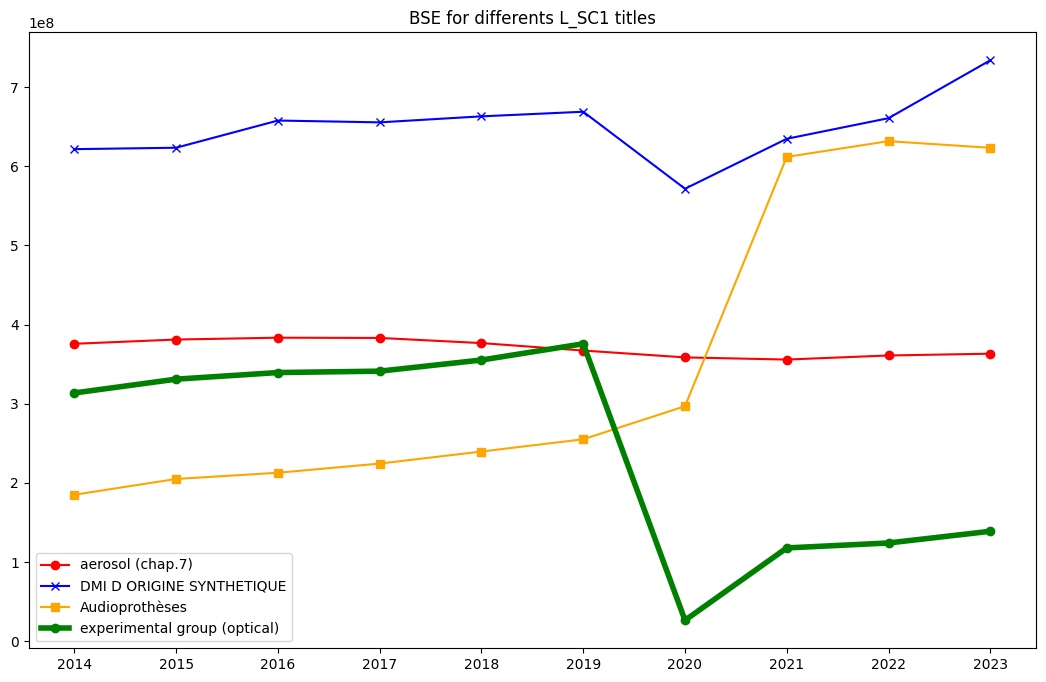

In [54]:
plt.figure(figsize=(13, 8))

plt.plot(
    list_years,
    control_group_1[4].values(),
    marker="o",
    color="red",
    label="Orthoprothèses (chap.7)",
)
plt.plot(
    list_years,
    control_group_2[4].values(),
    marker="x",
    color="blue",
    label="DMI D ORIGINE SYNTHETIQUE",
)
plt.plot(
    list_years,
    control_group_3[4].values(),
    marker="s",
    color="orange",
    label="Audioprothèses",
)
plt.plot(
    list_years,
    optical[4].values(),
    marker="o",
    color="green",
    label="experimental group (optical)",
    lw=4,
)

plt.title("BSE for differents L_SC1 titles")
plt.legend()

plt.show()

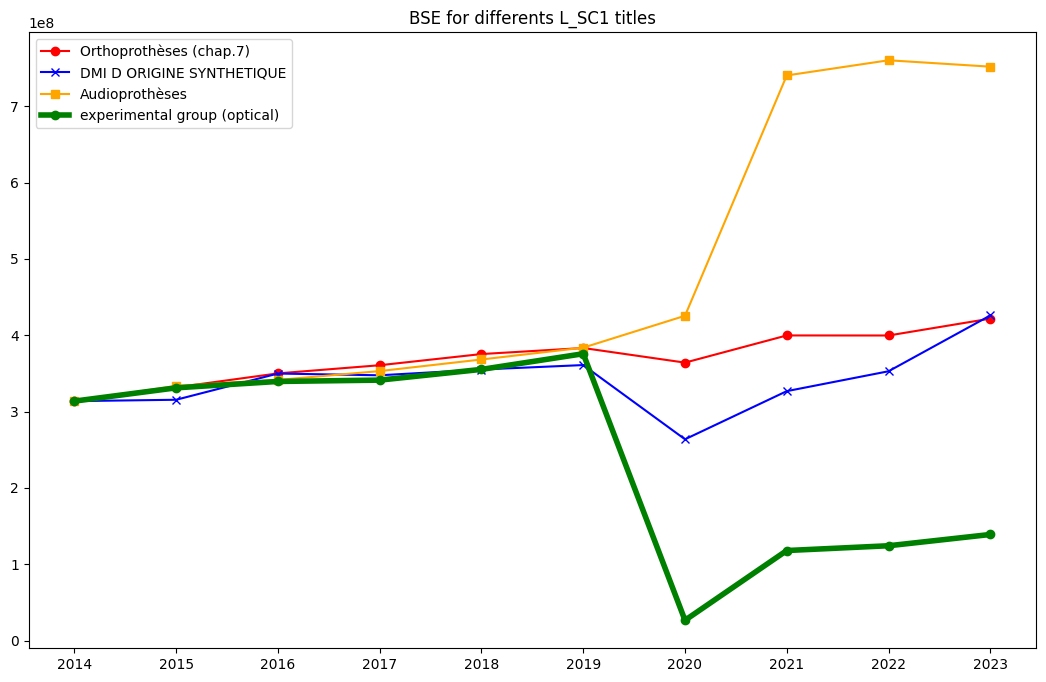

In [170]:
plt.figure(figsize=(13, 8))

plt.plot(
    list_years,
    [(value + 57663261.03999999) for value in control_group_1[4].values()],
    marker="o",
    color="red",
    label="Orthoprothèses (chap.7)",
)
plt.plot(
    list_years,
    [(value - 307897060.77000004) for value in control_group_2[4].values()],
    marker="x",
    color="blue",
    label="DMI D ORIGINE SYNTHETIQUE",
)
plt.plot(
    list_years,
    [(value + 128557520.13) for value in control_group_3[4].values()],
    marker="s",
    color="orange",
    label="Audioprothèses",
)
plt.plot(
    list_years,
    optical[4].values(),
    marker="o",
    color="green",
    label="experimental group (optical)",
    lw=4,
)

plt.title("BSE for differents L_SC1 titles")
plt.legend()

plt.show()

In [168]:
print(list(optical[4].values())[0] - list(control_group_1[4].values())[0])
print(list(optical[4].values())[0] - list(control_group_2[4].values())[0])
print(list(optical[4].values())[0] - list(control_group_3[4].values())[0])

57663261.03999999
-307897060.77000004
128557520.13
